## Dependencias

In [410]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score,accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from scikitplot.metrics import plot_roc

import pickle

## Espacios para aprendizaje

In [411]:
"""Cargamos los objetos importantes creados en nuestro eda"""
mapa_norm,mapa_woe,sc01,sc,im,pipe_pca,oh,best,vart,varn,vard,um,var,train,valid = pickle.load(open('objetos_persistencia.pkl','rb'))

In [412]:
"""Cargamos los distintos espacios de representación vectorial"""
X,X01,Xs,Xp,Xw = pickle.load(open('espacios.pkl','rb'))

In [413]:
"""Definimos el conjuunto de entrenamiento según la hiper caja elegida"""
Xt = Xp.copy()
Xt.shape
#Xt = Xt.loc[~Xt[um[0]].isin(list(Xw[np.isinf(Xw['amount'])][um[0]]))].reset_index(drop=True)

(2756, 29)

In [414]:
yt = Xt[um].merge(train[um+vart],on=um,how='inner')[vart[0]] #Guardamos la variable objetivo
Xt = Xt.drop(um,axis=1)

In [415]:
Xt.shape,yt.shape #comprobamos dimensiones

((2756, 28), (2756,))

## Aprendizaje

In [416]:
"""Instanciamos los modelos"""
lr = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier()
nn = MLPClassifier()
rf = RandomForestClassifier()

### Regresión Logística

In [417]:
"""Cargamos los hiperparametros de la reg logistica"""
hp = {"penalty" : ['l1', 'l2', 'elasticnet', 'none'],
"C": np.arange(0,2,0.1)}

In [418]:
"""Realizamos una busqueda de gradilla para encontrar los mejores hiperparametros"""
grid = GridSearchCV(estimator=lr,param_grid=hp,n_jobs=-1,verbose=True,scoring='accuracy',cv=4)

In [419]:
grid.fit(Xt,yt) #entrenamos el modelo

Fitting 4 folds for each of 80 candidates, totalling 320 fits


/home/jose/entornos/ins/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jose/entornos/ins/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jose/entornos/ins/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jose/entornos/ins/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jose/entornos/ins/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jose/entornos/ins/lib/python3.8/site-packages/sklearn/linea

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring='accuracy', verbose=True)

In [420]:
lr = grid.best_estimator_ #usamos el modelo ganador

In [421]:
grid.best_score_ #vemos el score obtenido

0.670899854862119

In [422]:
grid.best_params_ #visualizamos los hiperparametros ganadores

{'C': 0.1, 'penalty': 'l2'}

In [423]:
lr.fit(Xt,yt) #Entrenamos el mejor modelo

LogisticRegression(C=0.1, max_iter=1000)

#### Parámetros $\vec{\theta},\theta_0$

In [424]:
lr.coef_,lr.intercept_ #visulizamos los parametros del modelo de reg log

(array([[ 2.00901141, -1.03410889, -1.4399225 , -0.2591759 ,  0.16128314,
         -0.4027304 ,  0.02416195, -0.54751992,  0.27842383,  0.45923186,
         -0.37418931,  0.71334049,  0.25437603, -0.37488545, -0.036497  ,
          0.42565774, -0.13964822, -0.87509838,  0.07548016,  0.15701216,
          0.0256184 ,  0.24172712, -0.73330258, -0.39159351,  0.44654394,
          0.09904018,  0.4547693 , -0.39283233]]),
 array([0.49579587]))

In [425]:
"""Vemos sus metricas"""
print(accuracy_score(y_true=yt,y_pred=lr.predict(Xt)))
print(roc_auc_score(y_true=yt,y_score=lr.predict_proba(Xt)[:,1]))

0.6785195936139332
0.7375800606775662


### Árbol de Decisión

In [426]:
"""Hiperparametros del arbol de decision"""
hp = {"criterion" : ["gini", "entropy", "log_loss"],
"splitter" : ["best", "random"],
"max_depth" : range(2,Xt.shape[-1]),
"min_samples_split" : np.arange(0.01,0.1,0.01)}

In [427]:
"""Busqueda de gradilla"""
grid = GridSearchCV(estimator=dt,param_grid=hp,n_jobs=-1,verbose=True,scoring='accuracy',cv=4)

In [428]:
grid.fit(Xt,yt) #Buscamos los hiperparametros

Fitting 4 folds for each of 1404 candidates, totalling 5616 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(2, 28),
                         'min_samples_split': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=True)

In [429]:
dt = grid.best_estimator_ #guardamos el modelo con mejores hipeparametros

In [430]:
grid.best_score_ #vemos su escore

0.6418722786647315

In [431]:
grid.best_params_ #hipeparametros ganadores

{'criterion': 'entropy',
 'max_depth': 11,
 'min_samples_split': 0.08,
 'splitter': 'random'}

In [432]:
dt.fit(Xt,yt) #entrenamos el modelo con los mejores hiperparametros

DecisionTreeClassifier(criterion='entropy', max_depth=11,
                       min_samples_split=0.08, splitter='random')

#### Parámetros

In [433]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

[Text(0.65, 0.9583333333333334, '0 <= 0.563\nentropy = 1.0\nsamples = 2756\nvalue = [1360, 1396]'),
 Text(0.43333333333333335, 0.875, '2 <= 0.438\nentropy = 0.993\nsamples = 2032\nvalue = [1115, 917]'),
 Text(0.3, 0.7916666666666666, '2 <= 0.321\nentropy = 0.995\nsamples = 1060\nvalue = [485, 575]'),
 Text(0.23333333333333334, 0.7083333333333334, '5 <= 0.639\nentropy = 0.978\nsamples = 590\nvalue = [244, 346]'),
 Text(0.2, 0.625, '7 <= 0.596\nentropy = 0.968\nsamples = 566\nvalue = [224, 342]'),
 Text(0.16666666666666666, 0.5416666666666666, '21 <= 0.764\nentropy = 0.944\nsamples = 468\nvalue = [169, 299]'),
 Text(0.13333333333333333, 0.4583333333333333, '19 <= 0.605\nentropy = 0.935\nsamples = 458\nvalue = [161, 297]'),
 Text(0.1, 0.375, '2 <= 0.136\nentropy = 0.957\nsamples = 344\nvalue = [130, 214]'),
 Text(0.06666666666666667, 0.2916666666666667, 'entropy = 0.605\nsamples = 27\nvalue = [4, 23]'),
 Text(0.13333333333333333, 0.2916666666666667, '11 <= 0.755\nentropy = 0.969\nsamples 

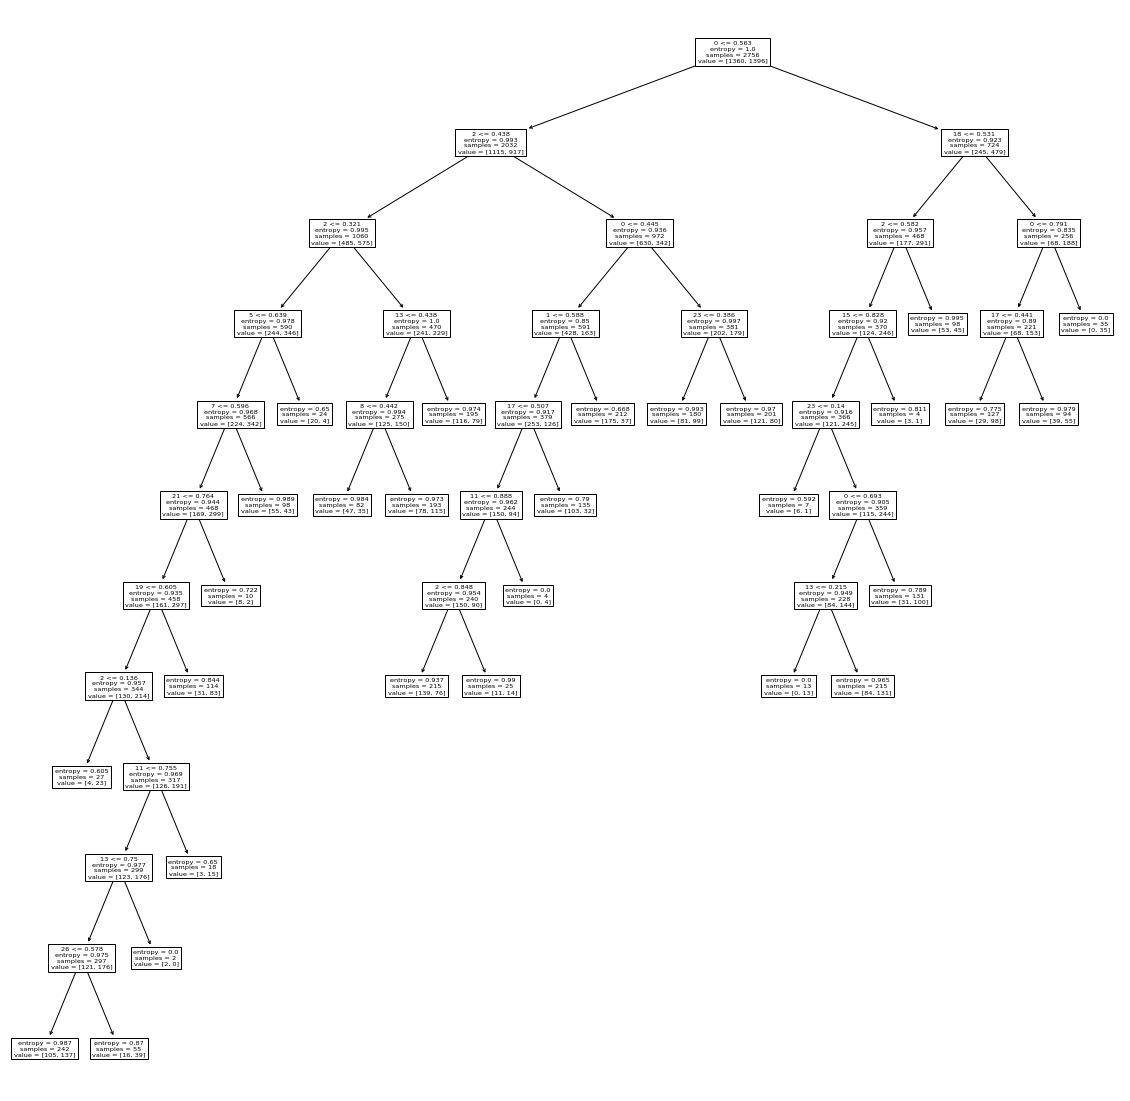

In [434]:
plt.figure(figsize=(20,20))
plot_tree(dt,feature_names=Xt.columns)

In [ ]:
"""Metricas"""
print(accuracy_score(y_true=yt,y_pred=dt.predict(Xt)))
print(roc_auc_score(y_true=yt,y_score=dt.predict_proba(Xt)[:,1]))

### Red Neuronal

In [435]:
"""Hiperparametros de la red neuronal"""
hp = {"activation" : ['identity', 'logistic', 'tanh', 'relu'],
"learning_rate" : ['constant', 'invscaling', 'adaptive'],
"hidden_layer_sizes": [(a,b, ) for a in range(2,8) for b in range(2,7)], #dos capas ocultas con un rango de 2 a 8 neuronas
"max_iter" : [1000] }

In [436]:
from functools import reduce
reduce(lambda x,y:x*y,map(len,[y for _,y in hp.items()])) #checamos las combinaciones posibles

360

In [437]:
from sklearn.model_selection import RandomizedSearchCV

In [438]:
"""Busqueda aleatoria ya que es menos pesada"""
grid = RandomizedSearchCV(estimator=nn,
param_distributions=hp,n_jobs=-1,verbose=True,scoring='accuracy',cv=4,n_iter=30)

In [439]:
grid.fit(Xt,yt) #buscamos los mejores hipeparametros

Fitting 4 folds for each of 30 candidates, totalling 120 fits


RandomizedSearchCV(cv=4, estimator=MLPClassifier(), n_iter=30, n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'hidden_layer_sizes': [(2, 2), (2, 3),
                                                               (2, 4), (2, 5),
                                                               (2, 6), (3, 2),
                                                               (3, 3), (3, 4),
                                                               (3, 5), (3, 6),
                                                               (4, 2), (4, 3),
                                                               (4, 4), (4, 5),
                                                               (4, 6), (5, 2),
                                                               (5, 3), (5, 4),
                                                               (5, 5), (5, 6),
                                                               (6, 2), (6, 3),
                                                               (6, 4), (6, 5),
                                                               (6, 6), (7, 2),
                                                               (7, 3), (7, 4),
                                                               (7, 5), (7, 6)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [1000]},
                   scoring='accuracy', verbose=True)

In [440]:
nn = grid.best_estimator_ #guardamos el modelo con los mejores hiperparamtros

In [441]:
grid.best_score_ #vemos su score

0.6669085631349783

In [442]:
grid.best_params_ #hiperparametros ganadores

{'max_iter': 1000,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (2, 6),
 'activation': 'identity'}

In [443]:
nn.fit(Xt,yt) #entrenamos el modelo con los mejores hipeparametros

MLPClassifier(activation='identity', hidden_layer_sizes=(2, 6),
              learning_rate='adaptive', max_iter=1000)

#### Parámetros $\mathcal{W}$

In [444]:
nn.coefs_ #parametros del modelo

[array([[-0.90581294, -0.93023798],
        [ 0.57376423,  0.20127513],
        [ 0.73228697,  0.40738788],
        [-0.00991365,  0.36591346],
        [-0.31994316,  0.36504193],
        [ 0.38067615, -0.03656497],
        [-0.01135323, -0.01963907],
        [-0.01950266,  0.73363341],
        [-0.1001725 , -0.02892924],
        [-0.29289139,  0.02882871],
        [ 0.10826233,  0.35152128],
        [-0.62427831,  0.20809585],
        [-0.2206763 ,  0.01689309],
        [-0.01294228,  0.44931277],
        [ 0.1355564 , -0.08363708],
        [-0.11076872, -0.21405879],
        [ 0.09619191,  0.13263651],
        [ 0.29789617,  0.57195272],
        [ 0.01582618, -0.07596786],
        [-0.11993101,  0.07993565],
        [ 0.0200492 ,  0.10990366],
        [-0.01651295, -0.21858118],
        [ 0.50958528,  0.06476941],
        [ 0.18754134,  0.23166827],
        [-0.3202824 ,  0.01673502],
        [-0.02268283, -0.11993349],
        [-0.25946257, -0.18822219],
        [ 0.32729532, -0.054

In [445]:
"""Mejores metricas"""
print(accuracy_score(y_true=yt,y_pred=nn.predict(Xt)))
print(roc_auc_score(y_true=yt,y_score=nn.predict_proba(Xt)[:,1]))

0.6734397677793904
0.7371702764200236


### Ensambles

In [446]:
"""Hiperparametros para un random forest"""
hp = {"n_estimators": range(1,50),"criterion" : ["gini", "entropy", "log_loss"],
"max_depth" : range(2,Xt.shape[-1]),
"min_samples_split" : np.arange(0.01,0.1,0.01)}

In [447]:
"""Combinaciones posibles de hiperparametros"""
from functools import reduce
reduce(lambda x,y:x*y,map(len,[y for _,y in hp.items()]))

34398

In [448]:
"""Busqueda aleatoria de hiperparametros"""
grid = RandomizedSearchCV(estimator=rf,
param_distributions=hp,n_jobs=-1,verbose=True,scoring='accuracy',cv=4,n_iter=200)

In [449]:
grid.fit(Xt,yt) #buscamos los mejores hiperparametros

Fitting 4 folds for each of 200 candidates, totalling 800 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': range(2, 28),
                                        'min_samples_split': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                                        'n_estimators': range(1, 50)},
                   scoring='accuracy', verbose=True)

In [450]:
rf = grid.best_estimator_ #guardamos el modelo con los mejores hp

In [451]:
grid.best_score_ #score del modelo

0.668722786647315

In [452]:
grid.best_params_ #mejores hiperparametros

{'n_estimators': 49,
 'min_samples_split': 0.03,
 'max_depth': 23,
 'criterion': 'gini'}

In [453]:
rf.fit(Xt,yt) #entrenamos el modelo ganador

RandomForestClassifier(max_depth=23, min_samples_split=0.03, n_estimators=49)

In [454]:
"""Metricas de valuacion"""
print(accuracy_score(y_true=yt,y_pred=rf.predict(Xt)))
print(roc_auc_score(y_true=yt,y_score=rf.predict_proba(Xt)[:,1]))

0.8113207547169812
0.8907458810888251


## Generalización

In [455]:
"""Llenamos los valores faltantes como missing en la porcion de validacion de las variables discretas"""
for v in vard:
    valid[v] = valid[v].fillna('MISSING')

In [456]:
"""Normalizamos las variables discetras en la porcopm de validación"""
for v,mapa in mapa_norm:
    valid[f'n_{v}'] = valid[v].map(mapa)

In [459]:
"""Repetimos las transformaciones aplicadas a la porcion de train pero ahora a la de validación"""
Xv = pd.DataFrame(im.transform(valid[best]),columns=best)
Xv[um] = valid[um]
Xv = Xv[um+best].copy().merge(valid[um+varn],on=um,how='inner')
Xv[oh.get_feature_names_out()] = oh.transform(Xv[varn]).toarray()
Xv.drop(varn,axis=1,inplace=True)
Xv = pd.DataFrame(sc01.transform(Xv[var]),columns=var)
Xv = pd.DataFrame(pipe_pca.transform(Xv[var]))
Xv.insert(0,um[0],valid[um])
yv = Xv[um].merge(valid[um+vart],on=um,how='inner')[vart[0]]
Xv = Xv.drop(um,axis=1)
Xv.shape,yv.shape #comprobamos dimensiones de la variables dependientes y la targed de la porcion de validación

((1200, 28), (1200,))

In [460]:
"""Porcion de validacion"""
print(accuracy_score(y_true=yv,y_pred=lr.predict(Xv)))
print(accuracy_score(y_true=yv,y_pred=dt.predict(Xv)))
print(accuracy_score(y_true=yv,y_pred=nn.predict(Xv)))
print(accuracy_score(y_true=yv,y_pred=rf.predict(Xv)))

0.6066666666666667
0.5525
0.5883333333333334
0.6108333333333333


In [461]:
"""Porcion de entrenamiento"""
print(accuracy_score(y_true=yt,y_pred=lr.predict(Xt)))
print(accuracy_score(y_true=yt,y_pred=dt.predict(Xt)))
print(accuracy_score(y_true=yt,y_pred=nn.predict(Xt)))
print(accuracy_score(y_true=yt,y_pred=rf
.predict(Xt)))

0.6785195936139332
0.6563860667634253
0.6734397677793904
0.8113207547169812


In [462]:
"""Porcion de validacion"""
print(roc_auc_score(y_true=yv,y_score=lr.predict_proba(Xv)[:,1]))
print(roc_auc_score(y_true=yv,y_score=dt.predict_proba(Xv)[:,1]))
print(roc_auc_score(y_true=yv,y_score=nn.predict_proba(Xv)[:,1]))
print(roc_auc_score(y_true=yv,y_score=rf.predict_proba(Xv)[:,1]))

0.6773081201334816
0.6090433815350389
0.6782591768631814
0.6616212458286985


In [463]:
"""Porcion de validacion"""
print(roc_auc_score(y_true=yt,y_score=lr.predict_proba(Xt)[:,1]))
print(roc_auc_score(y_true=yt,y_score=dt.predict_proba(Xt)[:,1]))
print(roc_auc_score(y_true=yt,y_score=nn.predict_proba(Xt)[:,1]))
print(roc_auc_score(y_true=yt,y_score=rf.predict_proba(Xt)[:,1]))

0.7375800606775662
0.7116198592617563
0.7371702764200236
0.8907458810888251


Podemos observar que tanto en accuracy como con el ROC tenemos presencia de sobreajuste en nuestros modelos dado que no estan generalizando en la porcion de validacion.
Dentro de las posibles soluciones es cambiar de hiperespacio, quitarle complejidad al modelo reduciendo los hiperparametros o ir a la parte del eda.

## Reportes

In [ ]:
Xt = X01.copy()
Xt[vart[0]] = yt

In [ ]:
nombres = ['reg','arb','red','rf']

for m,n in zip([lr,dt,nn,rf],nombres):
    Xt[f'p_{n}'] = m.predict_proba(Xt[var])[:,1]
Xt.drop(var,axis=1,inplace=True)
Xt = Xt.assign(muestra='ent')

In [ ]:
Xv[um] = valid[um]
Xv[vart[0]]=yv 
for m,n in zip([lr,dt,nn,rf],nombres):
    Xv[f'p_{n}'] = m.predict_proba(Xv[var])[:,1]
Xv.drop(var,axis=1,inplace=True)
Xv = Xv.assign(muestra='val')

In [ ]:
Xt.head()

,id_txn,is_fraud,p_reg,p_arb,p_red,p_rf,muestra
0,14562726,0,0.206604,0.000000,0.117145,0.296929,ent
1,8559729,1,0.351147,0.610390,0.451825,0.446684,ent
2,12242812,0,0.792146,0.691892,0.793174,0.481100,ent
3,211994,0,0.097207,0.000000,0.029749,0.164141,ent
4,3635657,0,0.631241,0.421053,0.663929,0.387736,ent


In [ ]:
Xv.head()

,id_txn,is_fraud,p_reg,p_arb,p_red,p_rf,muestra
0,1221262,1,0.350685,0.444444,0.261388,0.414085,val
1,13552667,0,0.773048,0.644295,0.792511,0.681296,val
2,4834947,0,0.247600,0.200000,0.163157,0.284701,val
3,14029755,1,0.495403,0.359155,0.346537,0.402838,val
4,20056061,1,0.464577,0.444444,0.519990,0.595219,val


In [ ]:
reporte = pd.concat([Xt,Xv],ignore_index=False)

In [ ]:
reporte.shape

(3956, 7)

In [ ]:
probas = list(reporte.filter(like='p_').columns)

for v in probas:
    reporte[v] = pd.cut(reporte[v],bins=np.arange(0,1.2,0.2),include_lowest=True).astype(str)

In [ ]:
reporte.groupby(probas+vart+['muestra']).count().to_clipboard() #copiamos el df en el portapapeles y lo pegamos en una hoja de google sheets